# Graph visualization

In [132]:
pip install networkx wikipedia-api

Note: you may need to restart the kernel to use updated packages.


## Imports and data loading

In [129]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
import wikipediaapi
import textwrap

if os.path.isdir('./lab5'):
    os.chdir('./lab5')

nodes_df = pd.read_csv('./data/nodes_a.csv')
edges_df = pd.read_csv('./data/edges_a.csv')

## Basic graph

### Creating the art graph

In [3]:
G = nx.Graph()

for row in nodes_df.itertuples():
    G.add_node(row.Id, label=row.Label)

for row in edges_df.itertuples():
    G.add_edge(row.Source, row.Target)

### Art graph plot

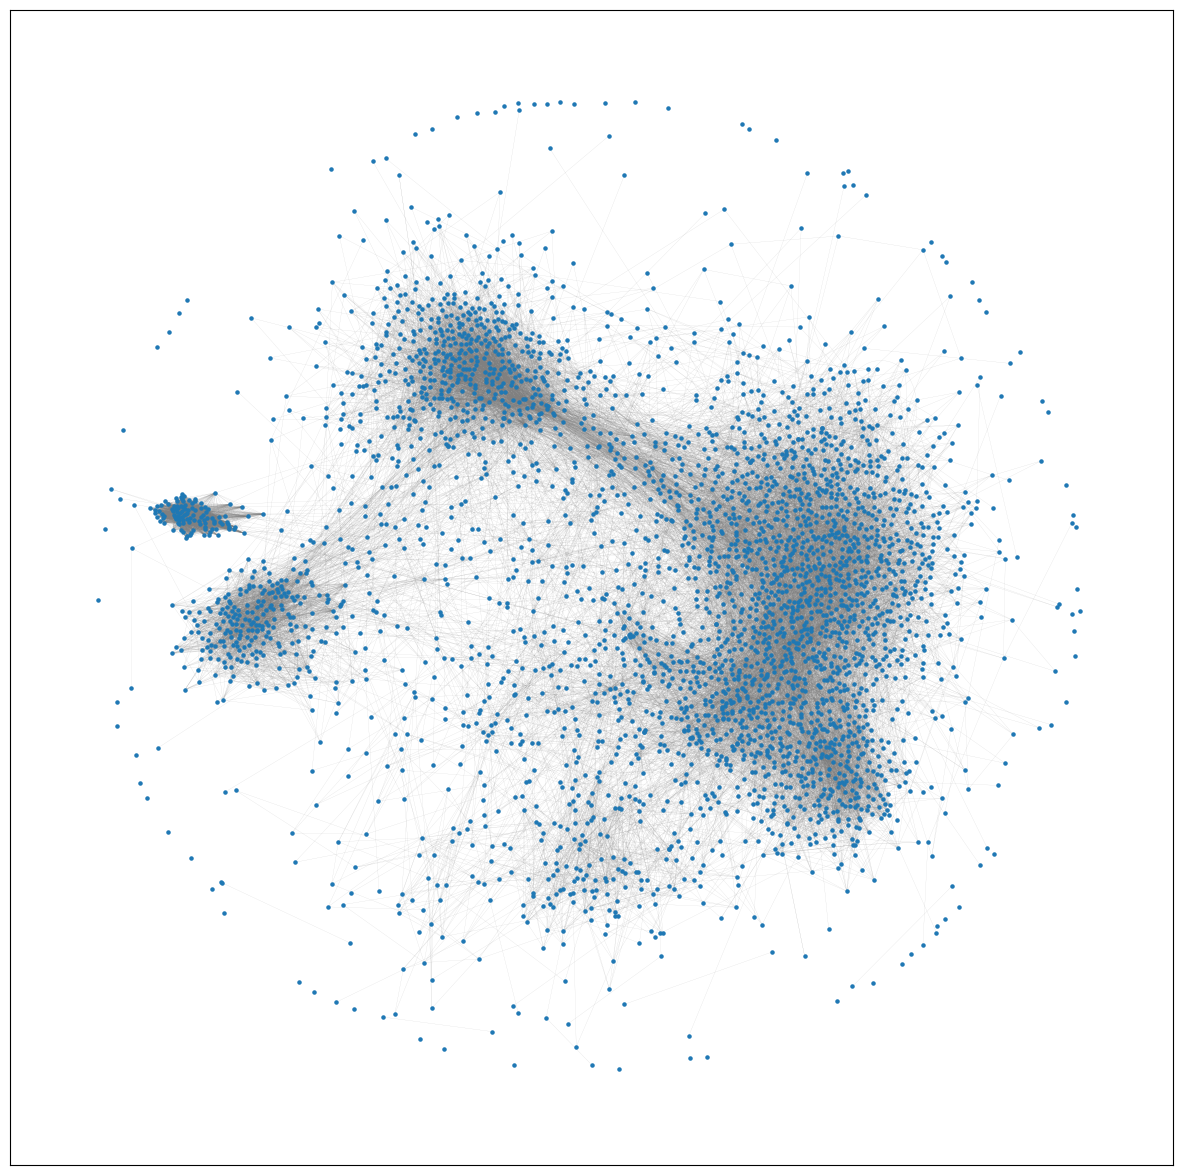

In [4]:
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=1, iterations=500)
nx.draw_networkx_nodes(G, pos, node_size=5)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.1, alpha=0.5)
plt.show()

## Most important modularities

### Plotting graph with colorized modularities

In [37]:
def detect_and_visualize_communities(
    G, pos, resolution=1.0, seed=None, size_threshold=3
):
    # Find communities using the Louvain method
    communities = community.louvain_communities(
        G, resolution=resolution, seed=seed
    )

    # Map each node to its community and calculate community sizes
    community_map = {node: idx for idx, comm in enumerate(communities) for node in comm}
    community_sizes = {idx: len(comm) for idx, comm in enumerate(communities)}

    # Set node attributes for community
    nx.set_node_attributes(G, community_map, "community")

    # Determine node colors based on community size
    node_colors = [
        (
            community_map[node]
            if community_sizes[community_map[node]] >= size_threshold
            else -1
        )
        for node in G.nodes()
    ]

    # Define a colormap where the -1 color (small communities) is gray
    cmap = plt.cm.rainbow
    cmap.set_under("gray")

    # Draw the graph
    plt.figure(figsize=(15, 15))
    nx.draw_networkx_nodes(
        G, pos, node_size=5, node_color=node_colors, cmap=cmap, vmin=0
    )
    nx.draw_networkx_edges(G, pos, edge_color="gray", width=0.1, alpha=0.5)
    plt.title(f"Communities Detected with Resolution {resolution}")
    plt.show()

    # Print community statistics for large communities
    large_community_sizes = sorted(
        [size for size in community_sizes.values() if size >= size_threshold],
        reverse=True,
    )
    print(f"Number of communities: {len(communities)}")
    print(
        f"Sizes of large communities (size >= {size_threshold}): {large_community_sizes}"
    )
    
    return communities

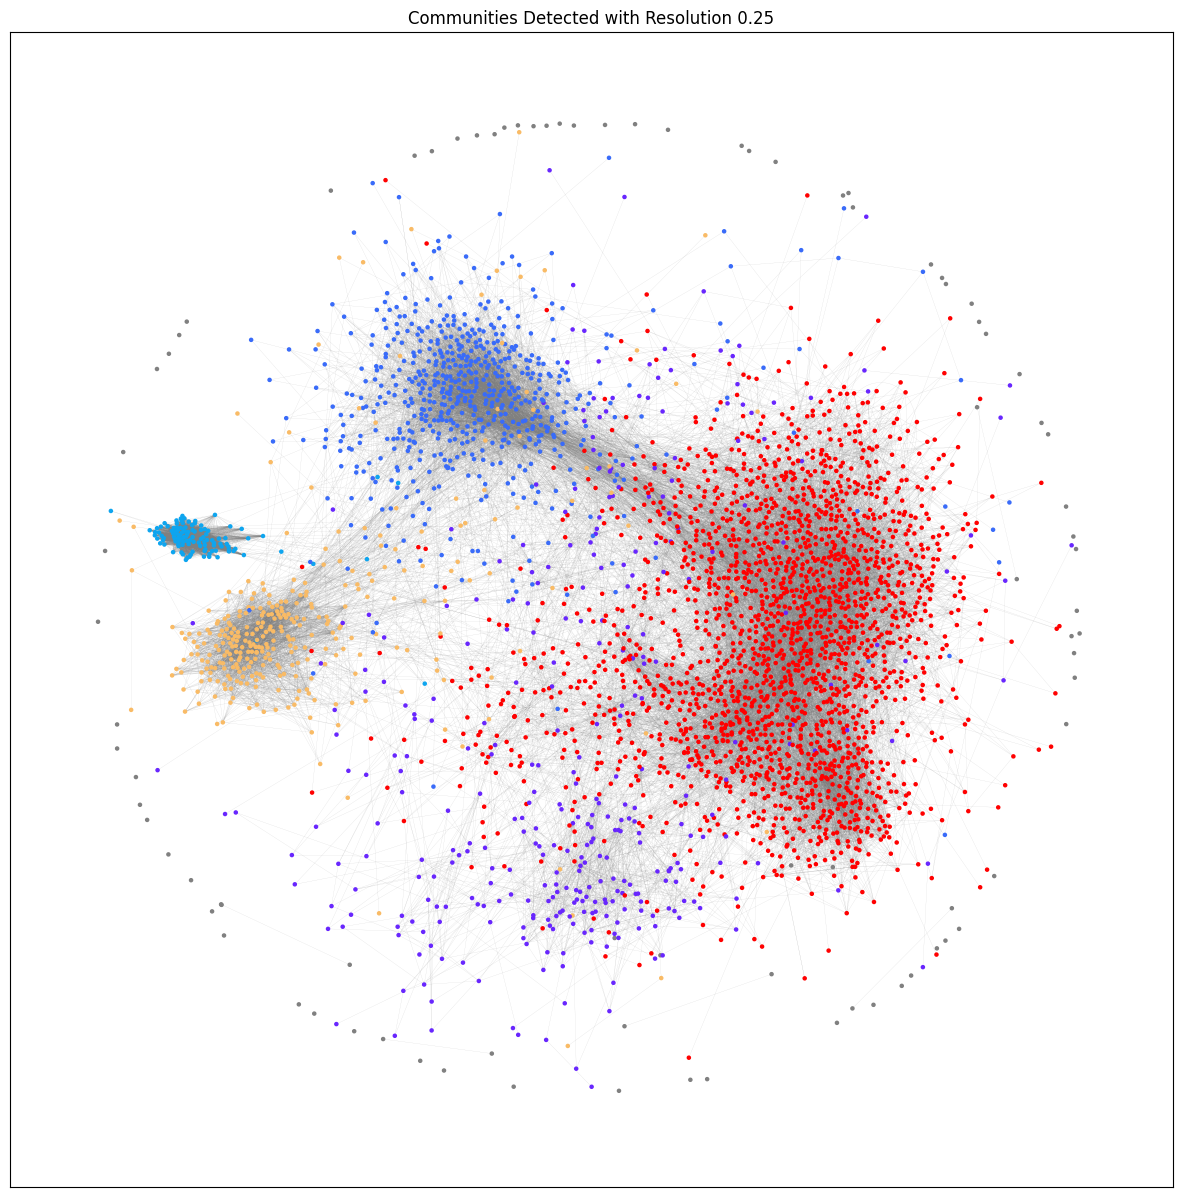

Number of communities: 85
Sizes of large communities (size >= 3): [2107, 614, 352, 323, 115]


In [38]:
communities = detect_and_visualize_communities(G, pos, resolution=0.25, seed=42)

### Identifying what is represented by largest modularities

In [42]:
communities_by_size = sorted(communities, key=len, reverse=True)

In [43]:
nodes_df[nodes_df['Id'].isin(communities_by_size[0])]

,Id,Label
0,4,Good Vibrations
2,166,The Pretenders
9,534,Fear of a Black Planet
10,548,It Takes a Nation of Millions to Hold Us Back
11,597,Small Faces
...,...,...
3584,259234,Guitar Hero (video game)
3590,259575,I Heard It Through the Grapevine
3594,260322,Scott Litt
3596,260340,Girl group


The group contains a diverse mix of music albums, bands, songs, video games, and a music producer.

In [44]:
nodes_df[nodes_df["Id"].isin(communities_by_size[1])]

,Id,Label
3,204,EverQuest
4,205,Ultima Online
5,396,The Elder Scrolls IV: Oblivion
6,397,Fallout 3
7,403,Fallout 4
...,...,...
3575,258100,N-Gage (service)
3583,259225,3rd Super Robot Wars Alpha: To the End of the ...
3585,259238,Capcom Classics Collection
3586,259411,Taito Memories


This group consists of various video games, gaming services, and game collections.

In [54]:
nodes_df[nodes_df["Id"].isin(communities_by_size[2])]

,Id,Label
20,1330,Mormon fundamentalism
46,3126,Japanese painting
49,3232,Moli?re
56,3602,Latvians
59,3792,Dutch Golden Age painting
...,...,...
3514,253249,Book of Jeremiah
3515,253251,Jeremiah
3531,255418,Christophe Rousset
3573,257683,Peplum (film genre)


This group includes a variety of cultural, religious, and historical topics, including religious movements, art forms, historical figures, nationalities, literature, and film genres.

In [52]:
nodes_df[nodes_df["Id"].isin(communities_by_size[3])]

,Id,Label
1,146,The New 52
8,425,The Dark Knight Rises
33,2014,Canadian comics
54,3373,1969 in comics
58,3724,Laverne Harding
...,...,...
3471,250647,Ultimate Spider-Man
3588,259505,Ultimate Marvel
3589,259546,The Incredible Hulk (comic book)
3592,260036,Marvel Comics Presents


This group includes various topics related to comics, including comic book series, comic book events, specific comic issues, and notable figures in the comic industry.

In [51]:
nodes_df[nodes_df["Id"].isin(communities_by_size[4])]

,Id,Label
864,58593,Miss Texas USA
906,61952,Miss Universe 2011
907,61953,Miss Universe 2012
908,61956,Miss Universe 2013
941,64328,Miss Trinidad and Tobago Universe
...,...,...
1531,98191,Miss Wisconsin USA
1532,98192,Miss Wyoming USA
1831,120367,Playboy Playmate
3438,247142,Miss Teen USA


This group consists of various beauty pageant titles and winners, including Miss USA titles, Miss Universe titles, and other related beauty contests.

## Calculation of centralities

### Of the whole graph

In [57]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
pagerank = nx.pagerank(G)

centralities_df = pd.DataFrame(
    {
        "node": list(G.nodes),
        "degree_centrality": [degree_centrality[node] for node in G.nodes],
        "betweenness_centrality": [betweenness_centrality[node] for node in G.nodes],
        "closeness_centrality": [closeness_centrality[node] for node in G.nodes],
        "eigenvector_centrality": [eigenvector_centrality[node] for node in G.nodes],
        "pagerank": [pagerank[node] for node in G.nodes],
    }
)

In [65]:
centralities_df

,node,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank
0,4,0.010286,0.002331,0.279213,2.267156e-06,0.000545
1,146,0.013344,0.005412,0.267984,2.580649e-06,0.000631
2,166,0.006394,0.001267,0.281323,8.572314e-07,0.000412
3,204,0.004170,0.000513,0.258889,3.315732e-06,0.000273
4,205,0.003614,0.000100,0.242657,2.288954e-06,0.000237
...,...,...,...,...,...,...
3593,260067,0.001390,0.000006,0.219094,9.116100e-08,0.000103
3594,260322,0.001668,0.000149,0.242468,1.224802e-07,0.000148
3595,260332,0.000834,0.000003,0.180840,1.198126e-09,0.000133
3596,260340,0.005560,0.000921,0.266711,2.314995e-06,0.000361


#### Degree centrality top nodes

In [70]:
centralities_df.sort_values("degree_centrality", ascending=False).head(5).merge(
    nodes_df, left_on="node", right_on="Id"
)

,node,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank,Id,Label
0,251890,0.062274,0.042796,0.325611,0.000061,0.003574,251890,Soul music
1,36497,0.058104,0.048154,0.335959,0.000083,0.002771,36497,Wii
2,251899,0.048374,0.028013,0.319238,0.000060,0.002975,251899,Contemporary R&B
3,122206,0.043369,0.028668,0.319030,0.000121,0.002562,122206,Rhythm and blues
4,228840,0.041979,0.020274,0.317374,0.000060,0.002045,228840,Nintendo DS


#### Betweenes centrality top nodes

In [71]:
centralities_df.sort_values("betweenness_centrality", ascending=False).head(5).merge(
    nodes_df, left_on="node", right_on="Id"
)

,node,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank,Id,Label
0,36497,0.058104,0.048154,0.335959,0.000083,0.002771,36497,Wii
1,251890,0.062274,0.042796,0.325611,0.000061,0.003574,251890,Soul music
2,68725,0.027245,0.039150,0.322060,0.000102,0.002311,68725,Broadway theatre
3,10377,0.023631,0.032119,0.322940,0.001956,0.001426,10377,Katy Perry
4,55120,0.039755,0.032003,0.329084,0.000093,0.001937,55120,PlayStation 4


#### Closeness centrality top nodes

In [72]:
centralities_df.sort_values("closeness_centrality", ascending=False).head(5).merge(
    nodes_df, left_on="node", right_on="Id"
)

,node,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank,Id,Label
0,36497,0.058104,0.048154,0.335959,0.000083,0.002771,36497,Wii
1,55120,0.039755,0.032003,0.329084,0.000093,0.001937,55120,PlayStation 4
2,251890,0.062274,0.042796,0.325611,0.000061,0.003574,251890,Soul music
3,121095,0.019183,0.009738,0.323887,0.000052,0.001017,121095,Rock Band
4,67979,0.015013,0.012268,0.323795,0.000043,0.000879,67979,2010 in downloadable songs for the Rock Band s...


#### Eigenvector centrality top nodes

In [73]:
centralities_df.sort_values("eigenvector_centrality", ascending=False).head(5).merge(
    nodes_df, left_on="node", right_on="Id"
)

,node,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank,Id,Label
0,84714,0.022519,0.000295,0.222092,0.141277,0.000425,84714,Miss USA 2011
1,84741,0.017793,0.004050,0.234709,0.114265,0.000343,84741,Miss USA 2014
2,98158,0.019183,0.000542,0.223922,0.113026,0.000376,98158,Miss California USA
3,98168,0.018627,0.000335,0.216109,0.110197,0.000353,98168,Miss Colorado USA
4,98159,0.018349,0.000506,0.223819,0.108489,0.000349,98159,Miss Louisiana USA


#### Pagerank top nodes

In [74]:
centralities_df.sort_values("pagerank", ascending=False).head(5).merge(
    nodes_df, left_on="node", right_on="Id"
)

,node,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank,Id,Label
0,251890,0.062274,0.042796,0.325611,0.000061,0.003574,251890,Soul music
1,251899,0.048374,0.028013,0.319238,0.000060,0.002975,251899,Contemporary R&B
2,36497,0.058104,0.048154,0.335959,0.000083,0.002771,36497,Wii
3,122206,0.043369,0.028668,0.319030,0.000121,0.002562,122206,Rhythm and blues
4,68725,0.027245,0.039150,0.322060,0.000102,0.002311,68725,Broadway theatre


### Of individual modularities

In [66]:
community_centralities = []
for c in communities:
    subgraph = G.subgraph(c)

    community_centralities.append(
        {
            "community": c,
            "degree_centrality": nx.degree_centrality(subgraph),
            "betweenness_centrality": nx.betweenness_centrality(subgraph),
            "closeness_centrality": nx.closeness_centrality(subgraph),
            "eigenvector_centrality": nx.eigenvector_centrality(subgraph),
            "pagerank": nx.pagerank(subgraph),
        }
    )

community_centralities_df = pd.DataFrame(
    [
        {
            "community": i,
            "node": node,
            "degree_centrality": centrality["degree_centrality"][node],
            "betweenness_centrality": centrality["betweenness_centrality"][node],
            "closeness_centrality": centrality["closeness_centrality"][node],
            "eigenvector_centrality": centrality["eigenvector_centrality"][node],
            "pagerank": centrality["pagerank"][node],
        }
        for i, centrality in enumerate(community_centralities)
        for node in centrality["community"]
    ]
)

In [67]:
community_centralities_df

,community,node,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank
0,0,17381,1.000000,0.00000,1.000000,0.707107,0.500000
1,0,1686,1.000000,0.00000,1.000000,0.707107,0.500000
2,1,17315,1.000000,0.00000,0.000000,1.000000,1.000000
3,2,17369,1.000000,0.00000,0.000000,1.000000,1.000000
4,3,19359,1.000000,0.00000,0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...
3593,80,180221,0.003799,0.00006,0.274362,0.001981,0.000324
3594,81,241834,1.000000,0.00000,0.000000,1.000000,1.000000
3595,82,250268,1.000000,0.00000,0.000000,1.000000,1.000000
3596,83,256230,1.000000,0.00000,0.000000,1.000000,1.000000


In [101]:
def top_labels_for_community_by_centralities(community_df, n=3):
    degree_top = community_df.nlargest(n, "degree_centrality")
    betweenness_top = community_df.nlargest(n, "betweenness_centrality")
    closeness_top = community_df.nlargest(n, "closeness_centrality")
    eigenvector_top = community_df.nlargest(n, "eigenvector_centrality")
    pagerank_top = community_df.nlargest(n, "pagerank")

    print("Top 3 by degree centrality:")
    print(nodes_df[nodes_df["Id"].isin(degree_top["node"])])
    print("\nTop 3 by betweenness centrality:")
    print(nodes_df[nodes_df["Id"].isin(betweenness_top["node"])])
    print("\nTop 3 by closeness centrality:")
    print(nodes_df[nodes_df["Id"].isin(closeness_top["node"])])
    print("\nTop 3 by eigenvector centrality:")
    print(nodes_df[nodes_df["Id"].isin(eigenvector_top["node"])])
    print("\nTop 3 by pagerank:")
    print(nodes_df[nodes_df["Id"].isin(pagerank_top["node"])])

#### Music community

In [112]:
music_centralities_df = community_centralities_df[
    community_centralities_df["node"].isin(communities_by_size[0])
]

top_labels_for_community_by_centralities(music_centralities_df)

Top 3 by degree centrality:
          Id              Label
1867  122206  Rhythm and blues 
3487  251890        Soul music 
3495  251899  Contemporary R&B 

Top 3 by betweenness centrality:
          Id              Label
1867  122206  Rhythm and blues 
3487  251890        Soul music 
3495  251899  Contemporary R&B 

Top 3 by closeness centrality:
          Id              Label
1867  122206  Rhythm and blues 
3487  251890        Soul music 
3495  251899  Contemporary R&B 

Top 3 by eigenvector centrality:
          Id                             Label
183    10542                 Lennon?McCartney 
2468  165281  The Beatles' recording sessions 
3487  251890                       Soul music 

Top 3 by pagerank:
          Id              Label
1867  122206  Rhythm and blues 
3487  251890        Soul music 
3495  251899  Contemporary R&B 


#### Video games community

In [113]:
video_games_centralities_df = community_centralities_df[
    community_centralities_df["node"].isin(communities_by_size[1])
]

top_labels_for_community_by_centralities(video_games_centralities_df)

Top 3 by degree centrality:
          Id                        Label
587    36497                         Wii 
1998  128596  Android (operating system) 
3246  228840                 Nintendo DS 

Top 3 by betweenness centrality:
          Id                        Label
1998  128596  Android (operating system) 
2603  177701                       Linux 
3246  228840                 Nintendo DS 

Top 3 by closeness centrality:
          Id                        Label
587    36497                         Wii 
1998  128596  Android (operating system) 
3246  228840                 Nintendo DS 

Top 3 by eigenvector centrality:
          Id          Label
587    36497           Wii 
1161   79025  Nintendo 3DS 
3246  228840   Nintendo DS 

Top 3 by pagerank:
          Id                        Label
587    36497                         Wii 
1998  128596  Android (operating system) 
3246  228840                 Nintendo DS 


#### Cultural community

In [114]:
cultural_centralities_df = community_centralities_df[
    community_centralities_df["node"].isin(communities_by_size[2])
]

top_labels_for_community_by_centralities(cultural_centralities_df)

Top 3 by degree centrality:
          Id            Label
350    21447          Talmud 
1341   89422           Moses 
2987  207315  Gospel of John 

Top 3 by betweenness centrality:
          Id    Label
350    21447  Talmud 
1341   89422   Moses 
3317  237448  Osiris 

Top 3 by closeness centrality:
          Id                   Label
457    29105  Resurrection of Jesus 
1341   89422                  Moses 
2987  207315         Gospel of John 

Top 3 by eigenvector centrality:
          Id                                Label
1341   89422                               Moses 
2962  204423  Life of Jesus in the New Testament 
2987  207315                      Gospel of John 

Top 3 by pagerank:
          Id                       Label
1341   89422                      Moses 
1624  104662  History of music in Paris 
2321  155580        History of painting 


#### Comic community

In [115]:
comics_centralities_df = community_centralities_df[
    community_centralities_df["node"].isin(communities_by_size[3])
]

top_labels_for_community_by_centralities(comics_centralities_df)

Top 3 by degree centrality:
          Id                              Label
711    46799                  Detective Comics 
1614  103899  Daredevil (Marvel Comics series) 
2498  168639                      Marv Wolfman 

Top 3 by betweenness centrality:
          Id                   Label
711    46799       Detective Comics 
1444   95343  Superman (comic book) 
2498  168639           Marv Wolfman 

Top 3 by closeness centrality:
          Id                   Label
711    46799       Detective Comics 
1444   95343  Superman (comic book) 
2498  168639           Marv Wolfman 

Top 3 by eigenvector centrality:
          Id              Label
711    46799  Detective Comics 
2498  168639      Marv Wolfman 
2936  202144          Len Wein 

Top 3 by pagerank:
          Id                 Label
711    46799     Detective Comics 
854    57723  Vertigo (DC Comics) 
2498  168639         Marv Wolfman 


#### Beauty community

In [116]:
beauty_centralities_df = community_centralities_df[
    community_centralities_df["node"].isin(communities_by_size[4])
]

top_labels_for_community_by_centralities(beauty_centralities_df)

Top 3 by degree centrality:
         Id                 Label
1239  84714        Miss USA 2011 
1498  98158  Miss California USA 
1508  98168    Miss Colorado USA 

Top 3 by betweenness centrality:
         Id                  Label
906   61952    Miss Universe 2011 
907   61953    Miss Universe 2012 
1504  98164  Miss Connecticut USA 

Top 3 by closeness centrality:
         Id                 Label
1239  84714        Miss USA 2011 
1491  98151    Miss Maryland USA 
1498  98158  Miss California USA 

Top 3 by eigenvector centrality:
         Id                 Label
1239  84714        Miss USA 2011 
1265  84741        Miss USA 2014 
1498  98158  Miss California USA 

Top 3 by pagerank:
         Id                 Label
1239  84714        Miss USA 2011 
1495  98155     Miss Georgia USA 
1498  98158  Miss California USA 


## Identifying Wikipedia articles for selected top centralities

In [138]:
# Initialize the Wikipedia API
user_agent = "GraphVisualization"
wiki_wiki = wikipediaapi.Wikipedia("en", headers={"User-Agent": user_agent})


def find_wikipedia_article(label):
    page = wiki_wiki.page(label)
    if page.exists():
        summary = page.summary[:500] # Get the first 500 characters of the summary
        url = page.fullurl
        return summary, url
    else:
        return "Article not found"


def print_wikipedia_article_summary(label):
    result = find_wikipedia_article(label)
    if result == "Article not found":
        print(f"{label} not found on Wikipedia")
        return
    summary, url = result
    wrapped_summary = textwrap.fill(summary, width=80)
    print(f"{label}:\n{wrapped_summary}\n{url}\n\n")

#### Top global centralities

In [133]:
print_wikipedia_article_summary("Soul music")

Soul music:
Soul music is a popular music genre that originated in the African-American
community throughout the United States in the late 1950s and early 1960s. It has
its roots in African-American gospel music and rhythm and blues. Soul music
became popular for dancing and listening, where U.S. record labels such as
Motown, Atlantic and Stax were influential during the Civil Rights Movement.
Soul also became popular around the world, directly influencing rock music and
the music of Africa. It also had a r
https://en.wikipedia.org/wiki/Soul_music




In [134]:
print_wikipedia_article_summary("Wii")

Wii:
The Wii (, WEE) is a home video game console developed and marketed by Nintendo.
It was released on November 19, 2006 in North America, and in December 2006 for
most other regions of the world. It is Nintendo's fifth major home game console,
following the GameCube and is a seventh-generation console alongside Microsoft's
Xbox 360 and Sony's PlayStation 3. In developing the Wii, Nintendo president
Satoru Iwata directed the company to avoid competing with Microsoft and Sony on
computational graphi
https://en.wikipedia.org/wiki/Wii




In [135]:
print_wikipedia_article_summary("Miss USA 2011")

Miss USA 2011:
Miss USA 2011 was the 60th Anniversary of the Miss USA pageant, held at the
Planet Hollywood Theatre for the Performing Arts in Las Vegas, Nevada on June
19, 2011. Rima Fakih of Michigan crowned her successor, Alyssa Campanella of
California, at the end of this event. This was California's sixth Miss USA title
and the first title since 1992. Campanella represented the United States at the
Miss Universe 2011 pageant in São Paulo, Brazil on September 12, 2011. This
pageant gained attention on the
https://en.wikipedia.org/wiki/Miss_USA_2011




#### Top local centralities

In [136]:
print_wikipedia_article_summary("Rhythm and blues")

Rhythm and blues:
Rhythm and blues, frequently abbreviated as R&B or R'n'B, is a genre of popular
music that originated within African-American communities in the 1940s. The term
was originally used by record companies to describe recordings marketed
predominantly to African Americans, at a time when "rocking, jazz based music
... [with a] heavy, insistent beat" was becoming more popular. In the commercial
rhythm and blues music typical of the 1950s through the 1970s, the bands usually
consisted of a piano, one o
https://en.wikipedia.org/wiki/Rhythm_and_blues




In [139]:
print_wikipedia_article_summary("Lennon McCartney")

Lennon McCartney not found on Wikipedia


In [140]:
print_wikipedia_article_summary("Linux")

Linux:
Linux ( LIN-uuks) is a family of open-source Unix-like operating systems based
on the Linux kernel, an operating system kernel first released on September 17,
1991, by Linus Torvalds. Linux is typically packaged as a Linux distribution
(distro), which includes the kernel and supporting system software and
libraries, many of which are provided by the GNU Project. Many Linux
distributions use the word "Linux" in their name, but the Free Software
Foundation uses and recommends the name "GNU/Linux"
https://en.wikipedia.org/wiki/Linux




In [141]:
print_wikipedia_article_summary("Talmud")

Talmud:
The Talmud (; Hebrew: תַּלְמוּד‎, romanized: Talmūḏ, lit. 'teaching') is the
central text of Rabbinic Judaism and the primary source of Jewish religious law
(halakha) and Jewish theology. Until the advent of modernity, in nearly all
Jewish communities, the Talmud was the centerpiece of Jewish cultural life and
was foundational to "all Jewish thought and aspirations", serving also as "the
guide for the daily life" of Jews. The term Talmud normally refers to the
collection of writings named specif
https://en.wikipedia.org/wiki/Talmud




In [142]:
print_wikipedia_article_summary("Resurrection of Jesus")

Resurrection of Jesus:
The resurrection of Jesus (Biblical Greek: ἀνάστασις τοῦ Ἰησοῦ, romanized:
anástasis toú Iēsoú) is the Christian belief that God raised Jesus from the dead
on the third day after his crucifixion, starting – or restoring – his exalted
life as Christ and Lord. According to the New Testament writing, Jesus was
firstborn from the dead, ushering in the Kingdom of God. He appeared to his
disciples, calling the apostles to the Great Commission of forgiving sin and
baptizing repenters, and ascended to H
https://en.wikipedia.org/wiki/Resurrection_of_Jesus




In [143]:
print_wikipedia_article_summary("Moses")

Moses:
Moses was a Hebrew prophet, teacher and leader, according to Abrahamic
tradition. He is considered the most important prophet in Judaism and
Samaritanism, and one of the most important prophets in Christianity, Islam, the
Baháʼí Faith, and other Abrahamic religions. According to both the Bible and the
Quran, Moses was the leader of the Israelites and lawgiver to whom the prophetic
authorship of the Torah (the first five books of the Bible) is attributed.
According to the Book of Exodus, Moses wa
https://en.wikipedia.org/wiki/Moses




In [144]:
print_wikipedia_article_summary("Detective Comics")

Detective Comics:
Detective Comics (later retitled as Batman Detective Comics) is an American
comic book series published by Detective Comics, later shortened to DC Comics.
The first volume, published from 1937 to 2011 (and later continued in 2016), is
best known for introducing the superhero Batman in Detective Comics #27 (cover-
dated May 1939). A second series of the same title was launched in September
2011, but in 2016, reverted to the original volume numbering. The series is the
source of its publishing comp
https://en.wikipedia.org/wiki/Detective_Comics




In [145]:
print_wikipedia_article_summary("Miss Universe 2011")

Miss Universe 2011:
Miss Universe 2011 was the 60th Miss Universe pageant, held at the Credicard
Hall in São Paulo, Brazil on 12 September 2011. At the end of the event, Ximena
Navarrete of Mexico crowned Leila Lopes of Angola as Miss Universe 2011, marking
the country's first win in the pageant's history. Contestants from eighty-nine
countries and territories competed in this year's pageant, surpassing the
previous record of 86 contestants in 2006. The pageant was hosted by Andy Cohen
and Natalie Morales, with com
https://en.wikipedia.org/wiki/Miss_Universe_2011


